In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import LSTM, Dense
import math
from sklearn.model_selection import train_test_split

In [2]:
# Đọc dữ liệu từ file CSV, lấy các cột cần thiết và phân tích cột 'Date' làm chỉ mục
df = pd.read_csv('dataset.csv', usecols=['Date', 'Price', 'Open', 'High', 'Low'])

# Đặt cột Date làm index (thiếu dòng này)
df['Date'] = pd.to_datetime(df['Date'])     # Chuyển sang datetime
df.set_index('Date', inplace=True) 

# Loại bỏ các dòng có giá trị thiếu (NaN) trong dữ liệu
df = df.dropna()

print(df.head())

             Price    Open    High     Low
Date                                      
2010-01-04  1118.3  1099.0  1124.6  1093.8
2010-01-05  1118.7  1122.0  1129.6  1115.5
2010-01-06  1136.5  1118.5  1141.0  1116.8
2010-01-07  1133.7  1139.0  1139.5  1128.7
2010-01-08  1138.9  1131.5  1140.0  1119.5


In [3]:
def create_dataset(dataset, time_step=1):
    """
    Tạo một dataset từ chuỗi thời gian, sử dụng cửa sổ trượt (sliding window).
    
    Parameters:
        dataset: Một mảng 1 chiều chứa các giá trị chuỗi thời gian
        time_step: Số bước thời gian dùng để dự báo bước tiếp theo
        
    Returns:
        dataX: Mảng các đoạn chuỗi đầu vào, mỗi đoạn có độ dài time_step
        dataY: Mảng các giá trị dự đoán tương ứng với mỗi đoạn đầu vào
    """
    dataX, dataY = [], []
    for i in range(len(dataset) - time_step):
        # Lấy đoạn time_step giá trị liên tiếp làm đầu vào X
        a = dataset[i:(i + time_step)]
        dataX.append(a)
        # Giá trị tiếp theo làm đầu ra Y
        dataY.append(dataset[i + time_step])
    return np.array(dataX), np.array(dataY)

In [4]:
# Dùng MinMaxScaler để chuẩn hóa về [0, 1] cho cột Price
scaler = MinMaxScaler(feature_range=(0, 1))
price_scaled = scaler.fit_transform(df[['Price']])

# Chuyển về mảng 1 chiều để xử lý dễ dàng hơn
price_data = price_scaled.flatten()

# Thiết lập tham số thời gian
time_step = 10

# Phân chia dữ liệu thành train và test
train_size = int(len(price_data) * 0.8)
test_size = len(price_data) - train_size
train_data = price_data[0:train_size]
test_data = price_data[train_size:len(price_data)]

# Tạo dataset cho train và test
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

# Reshape đầu vào cho LSTM [samples, time steps, features]
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

X_train shape: (3122, 10, 1), y_train shape: (3122,)
X_test shape: (773, 10, 1), y_test shape: (773,)


In [5]:
# Import cần thiết
import keras_tuner as kt
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

# Chia tập huấn luyện thành train và validation
validation_size = int(len(X_train) * 0.1)
X_val = X_train[-validation_size:]
y_val = y_train[-validation_size:]
X_train_tune = X_train[:-validation_size]
y_train_tune = y_train[:-validation_size]

In [6]:
import tensorflow as tf

# Định nghĩa hàm xây dựng mô hình với hyperparameter tuning
def build_model(hp):
    model = Sequential()
    
    # Lớp LSTM đầu tiên với L2 regularization mạnh hơn
    model.add(LSTM(
        units=hp.Int('units_1', min_value=32, max_value=128, step=32),  # Giảm số units tối đa
        return_sequences=False,  # Simplify model
        input_shape=(time_step, 1),
        activation=hp.Choice('activation', values=['relu', 'tanh']),
        recurrent_regularizer=tf.keras.regularizers.l2(hp.Float('recurrent_l2', min_value=1e-5, max_value=1e-3, sampling='log')),  # Thêm regularization cho recurrent weights
        kernel_regularizer=tf.keras.regularizers.l2(hp.Float('l2', min_value=1e-5, max_value=1e-3, sampling='log'))
    ))
    
    # Dropout cao hơn
    model.add(Dropout(hp.Float('dropout_1', min_value=0.3, max_value=0.5, step=0.1)))  # Tăng dropout tối thiểu
    
    # Lớp đầu ra 
    model.add(Dense(1))
    
    # Compile mô hình với learning rate được điều chỉnh
    optimizer_choice = hp.Choice('optimizer', values=['adam', 'rmsprop'])
    learning_rate = hp.Float('learning_rate', min_value=1e-5, max_value=1e-3, sampling='log')
    
    if optimizer_choice == 'adam':
        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    else:
        optimizer = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)
    
    model.compile(
        optimizer=optimizer,
        loss='mean_squared_error'
    )
    return model
# Cài đặt Keras Tuner
tuner = kt.RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=10,
    executions_per_trial=1,
    directory='tuning_lstm',
    project_name='gold_price_optimized'
)

# Tiến hành tìm kiếm siêu tham số
tuner.search(
    X_train_tune, y_train_tune,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,  # Sử dụng giá trị mặc định, batch_size sẽ được tối ưu trong build_model nếu cần
    verbose=1
)

# Lấy mô hình tốt nhất
best_model = tuner.get_best_models(num_models=1)[0]
best_hp = tuner.get_best_hyperparameters()[0]

print("Best hyperparameters:")
for param, value in best_hp.values.items():
    print(f"{param}: {value}")

# Hiển thị tóm tắt mô hình
best_model.summary()

Reloading Tuner from tuning_lstm\gold_price_optimized\tuner0.json

Best hyperparameters:
units_1: 224
return_sequences: False
activation: tanh
dropout_1: 0.0
optimizer: adam
recurrent_l2: 1e-05
l2: 1e-05
learning_rate: 1e-05


c:\Users\HUNG\anaconda3\envs\uitktdl\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
c:\Users\HUNG\anaconda3\envs\uitktdl\Lib\site-packages\keras\src\saving\saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 12 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 224)            │       202,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 224)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           225 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 202,721 (791.88 KB)

 Trainable params: 202,721 (791.88 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
72/79 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0027

79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0027 - val_loss: 0.0027 - learning_rate: 1.0000e-05
Epoch 2/50
78/79 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0027

79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0027 - val_loss: 0.0027 - learning_rate: 1.0000e-05
Epoch 3/50
78/79 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0026

79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0026 - val_loss: 0.0026 - learning_rate: 1.0000e-05
Epoch 4/50
74/79 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0026

79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0026 - val_loss: 0.0025 - learning_rate: 1.0000e-05
Epoch 5/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0025

79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0025 - val_loss: 0.0025 - learning_rate: 1.0000e-05
Epoch 6/50
77/79 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0024

79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0024 - val_loss: 0.0024 - learning_rate: 1.0000e-05
Epoch 7/50
75/79 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0024

79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0024 - val_loss: 0.0024 - learning_rate: 1.0000e-05
Epoch 8/50
77/79 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0023

79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0023 - val_loss: 0.0023 - learning_rate: 1.0000e-05
Epoch 9/50
74/79 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0022

79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0022 - val_loss: 0.0022 - learning_rate: 1.0000e-05
Epoch 10/50
75/79 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0022

79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0022 - val_loss: 0.0022 - learning_rate: 1.0000e-05
Epoch 11/50
76/79 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0021

79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0021 - val_loss: 0.0021 - learning_rate: 1.0000e-05
Epoch 12/50
78/79 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0021

79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0021 - val_loss: 0.0021 - learning_rate: 1.0000e-05
Epoch 13/50
77/79 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0020

79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0020 - val_loss: 0.0020 - learning_rate: 1.0000e-05
Epoch 14/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0020

79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0020 - val_loss: 0.0020 - learning_rate: 1.0000e-05
Epoch 15/50
77/79 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0019

79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0019 - val_loss: 0.0019 - learning_rate: 1.0000e-05
Epoch 16/50
74/79 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0019

79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0019 - val_loss: 0.0019 - learning_rate: 1.0000e-05
Epoch 17/50
74/79 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0018

79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0018 - val_loss: 0.0018 - learning_rate: 1.0000e-05
Epoch 18/50
74/79 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0018

79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0018 - val_loss: 0.0018 - learning_rate: 1.0000e-05
Epoch 19/50
76/79 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0017

79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0017 - val_loss: 0.0017 - learning_rate: 1.0000e-05
Epoch 20/50
72/79 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0017

79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0017 - val_loss: 0.0017 - learning_rate: 1.0000e-05
Epoch 21/50
77/79 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0016

79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0016 - val_loss: 0.0016 - learning_rate: 1.0000e-05
Epoch 22/50
76/79 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0016

79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0016 - val_loss: 0.0016 - learning_rate: 1.0000e-05
Epoch 23/50
77/79 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0015

79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0015 - val_loss: 0.0015 - learning_rate: 1.0000e-05
Epoch 24/50
75/79 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0015

79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0015 - val_loss: 0.0015 - learning_rate: 1.0000e-05
Epoch 25/50
75/79 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0015

79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0015 - val_loss: 0.0015 - learning_rate: 1.0000e-05
Epoch 26/50
78/79 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0014

79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0014 - val_loss: 0.0014 - learning_rate: 1.0000e-05
Epoch 27/50
73/79 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0014

79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0014 - val_loss: 0.0014 - learning_rate: 1.0000e-05
Epoch 28/50
78/79 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0013

79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0013 - val_loss: 0.0014 - learning_rate: 1.0000e-05
Epoch 29/50
75/79 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0013

79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0013 - val_loss: 0.0013 - learning_rate: 1.0000e-05
Epoch 30/50
78/79 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0013

79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0013 - val_loss: 0.0013 - learning_rate: 1.0000e-05
Epoch 31/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0012

79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0012 - val_loss: 0.0012 - learning_rate: 1.0000e-05
Epoch 32/50
77/79 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0012

79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0012 - val_loss: 0.0012 - learning_rate: 1.0000e-05
Epoch 33/50
76/79 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0012

79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0012 - val_loss: 0.0012 - learning_rate: 1.0000e-05
Epoch 34/50
74/79 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0011

79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0011 - val_loss: 0.0012 - learning_rate: 1.0000e-05
Epoch 35/50
78/79 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0011

79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0011 - val_loss: 0.0011 - learning_rate: 1.0000e-05
Epoch 36/50
76/79 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0011

79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0011 - val_loss: 0.0011 - learning_rate: 1.0000e-05
Epoch 37/50
76/79 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0011

79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0011 - val_loss: 0.0011 - learning_rate: 1.0000e-05
Epoch 38/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0010

79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0010 - val_loss: 0.0010 - learning_rate: 1.0000e-05
Epoch 39/50
75/79 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 9.9954e-04

79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 9.9889e-04 - val_loss: 0.0010 - learning_rate: 1.0000e-05
Epoch 40/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 9.6623e-04

79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 9.6618e-04 - val_loss: 9.8518e-04 - learning_rate: 1.0000e-05
Epoch 41/50
77/79 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 9.4337e-04

79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 9.4312e-04 - val_loss: 9.5999e-04 - learning_rate: 1.0000e-05
Epoch 42/50
75/79 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 9.1716e-04

79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 9.1681e-04 - val_loss: 9.3483e-04 - learning_rate: 1.0000e-05
Epoch 43/50
77/79 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 8.9206e-04

79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 8.9187e-04 - val_loss: 9.1065e-04 - learning_rate: 1.0000e-05
Epoch 44/50
77/79 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 8.6842e-04

79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 8.6823e-04 - val_loss: 8.8736e-04 - learning_rate: 1.0000e-05
Epoch 45/50
74/79 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 8.4380e-04

79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 8.4354e-04 - val_loss: 8.6488e-04 - learning_rate: 1.0000e-05
Epoch 46/50
77/79 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 8.2270e-04

79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 8.2251e-04 - val_loss: 8.4269e-04 - learning_rate: 1.0000e-05
Epoch 47/50
75/79 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 8.0173e-04

79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 8.0137e-04 - val_loss: 8.2106e-04 - learning_rate: 1.0000e-05
Epoch 48/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 7.7880e-04

79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 7.7875e-04 - val_loss: 8.0006e-04 - learning_rate: 1.0000e-05
Epoch 49/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 7.5828e-04

79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 7.5822e-04 - val_loss: 7.7971e-04 - learning_rate: 1.0000e-05
Epoch 50/50
72/79 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 7.3997e-04

79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 7.3940e-04 - val_loss: 7.6034e-04 - learning_rate: 1.0000e-05
Restoring model weights from the end of the best epoch: 50.


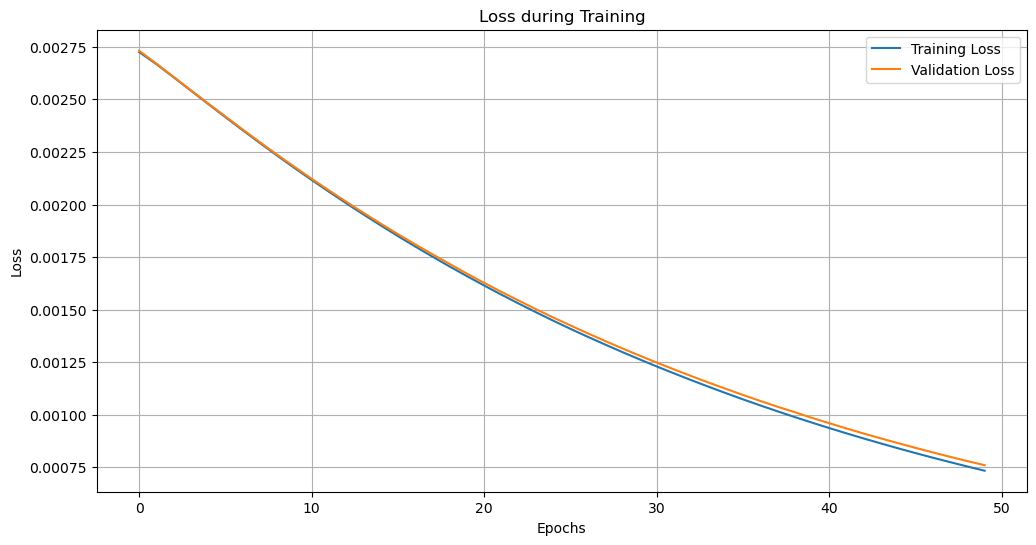

In [7]:
# Import thêm ReduceLROnPlateau
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# Lưu mô hình tốt nhất
checkpoint = ModelCheckpoint("best_model.h5", monitor='val_loss', save_best_only=True)

# Early stopping với patience thấp hơn
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,         # Giảm từ 15 xuống 10
    restore_best_weights=True,
    verbose=1
)

# Thêm ReduceLROnPlateau để điều chỉnh learning rate
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,          # Giảm learning rate với hệ số 0.5
    patience=10,         # Sau 10 epochs không cải thiện
    min_lr=1e-6,
    verbose=1
)

# Huấn luyện mô hình tốt nhất
history = best_model.fit(
    X_train, y_train,
    epochs=50,          # Giảm từ 100 xuống 50
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stop, checkpoint, reduce_lr],
    verbose=1
)

# Vẽ biểu đồ loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss during Training')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [8]:
# Dự đoán trên tập test
predictions = best_model.predict(X_test)

# Chuyển đổi giá trị dự đoán và thực tế về thang đo ban đầu
predictions_rescaled = scaler.inverse_transform(predictions)
y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))

# Đánh giá mô hình
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, r2_score

# Tính toán các chỉ số
mae = mean_absolute_error(y_test_rescaled, predictions_rescaled)
mape = mean_absolute_percentage_error(y_test_rescaled, predictions_rescaled) * 100
rmse = np.sqrt(mean_squared_error(y_test_rescaled, predictions_rescaled))
r2 = r2_score(y_test_rescaled, predictions_rescaled)

print(f"MAE: {mae:.2f}")
print(f"MAPE: {mape:.2f}%")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.4f}")

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
MAE: 16.69
MAPE: 0.74%
RMSE: 24.49
R²: 0.9967


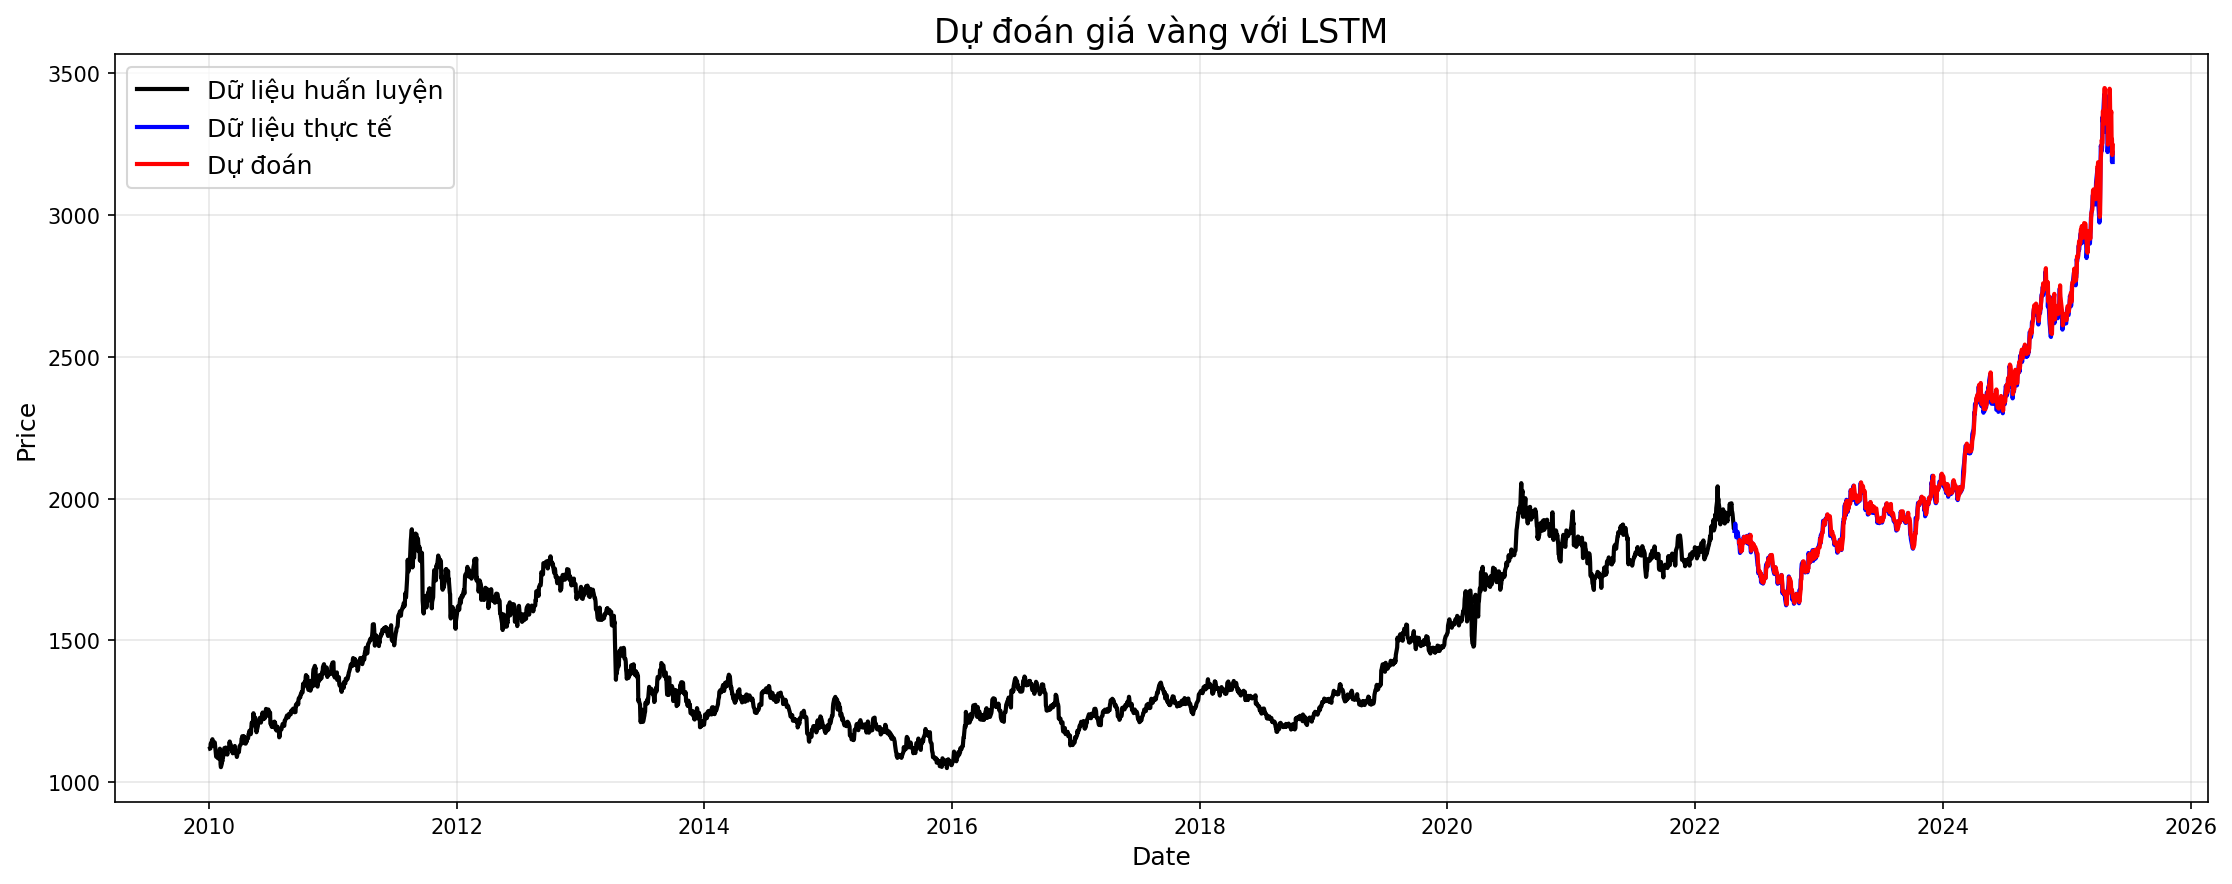

In [9]:
# Vẽ biểu đồ kết quả
plt.figure(figsize=(15, 6), dpi=150)

# Tạo mảng date cho dữ liệu test (đã có các chỉ mục ngày)
train_dates = df.index[:train_size]
test_dates = df.index[train_size:]

# Vẽ dữ liệu train
train_values = scaler.inverse_transform(train_data.reshape(-1, 1))
plt.plot(train_dates, train_values, color='black', lw=2, label='Dữ liệu huấn luyện')

# Vẽ dữ liệu test thực tế
test_values = scaler.inverse_transform(test_data.reshape(-1, 1))
plt.plot(test_dates[:len(test_values)], test_values, color='blue', lw=2, label='Dữ liệu thực tế')

# Vẽ dữ liệu dự đoán (cần điều chỉnh ngày)
test_dates_pred = test_dates[time_step:len(test_dates)]
plt.plot(test_dates_pred[:len(predictions_rescaled)], predictions_rescaled, color='red', lw=2, label='Dự đoán')

plt.title('Dự đoán giá vàng với LSTM', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

In [10]:
# Lưu mô hình đã huấn luyện
best_model.save('gold_price_model.h5')

# Lưu scaler để chuẩn hóa dữ liệu đầu vào
import pickle
with open('scaler.pkl', 'wb') as file:
    pickle.dump(scaler, file)